# 1. Import Libraries

In [0]:
import numpy as np
import pandas as pd
import os
import contractions
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import re
import spacy
nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from gensim.models.fasttext import FastText
from sklearn.decomposition import PCA
import plotly.express as px
import pickle

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Read the data

In [0]:
reddit_corpus = pd.read_csv("data/reddit_corpus_urgenta.csv")
reddit_corpus.head(2)

,title,score,id,url,comms_num,time,body,en_titles,en_bodies,posts,word_len_posts,word_len_comms,word_len_en_titles,word_len_en_bodies,word_len_ro_titles,word_len_ro_bodies
0,protocol de tratament coronavirus RO,0,fjsnox,https://i.imgur.com/3EFbJYo.jpg,5,2020-03-17 05:20:49,NaN,the protocol for the treatment of a coronaviru...,NaN,the protocol for the treatment of a coronaviru...,9,109,9,0,5,0
1,Ce soluții credeți ca ar trebui implementate î...,0,fjvs4g,https://www.reddit.com/r/Romania/comments/fjvs...,1,2020-03-17 08:34:17,NaN,What do you think it would have to be implemen...,NaN,What do you think it would have to be implemen...,21,43,21,0,15,0


In [0]:
# Drop unnecessary columns
reddit_corpus = reddit_corpus.drop(columns = ["url", "id"])
reddit_corpus.head(2)

,title,score,comms_num,time,body,en_titles,en_bodies,posts,word_len_posts,word_len_comms,word_len_en_titles,word_len_en_bodies,word_len_ro_titles,word_len_ro_bodies
0,protocol de tratament coronavirus RO,0,5,2020-03-17 05:20:49,NaN,the protocol for the treatment of a coronaviru...,NaN,the protocol for the treatment of a coronaviru...,9,109,9,0,5,0
1,Ce soluții credeți ca ar trebui implementate î...,0,1,2020-03-17 08:34:17,NaN,What do you think it would have to be implemen...,NaN,What do you think it would have to be implemen...,21,43,21,0,15,0


# 3. Preprocess data

In [0]:
# Check data types in corpus
reddit_corpus.dtypes

title                 object
score                  int64
comms_num              int64
time                  object
body                  object
en_titles             object
en_bodies             object
posts                 object
word_len_posts         int64
word_len_comms         int64
word_len_en_titles     int64
word_len_en_bodies     int64
word_len_ro_titles     int64
word_len_ro_bodies     int64
dtype: object

In [0]:
# # Transform data types to strings for easy management
reddit_corpus['posts'] = reddit_corpus['posts'].astype(str)
reddit_corpus['en_titles'] = reddit_corpus['posts'].astype(str)
reddit_corpus['en_bodies'] = reddit_corpus['en_bodies'].astype(str)
reddit_corpus['title'] = reddit_corpus['title'].astype(str)
reddit_corpus['body'] = reddit_corpus['body'].astype(str)

Text(0.5, 1.0, 'Comments number frequency')

Text(0.5, 0, 'Number of comments')

Text(0, 0.5, 'Frequency')

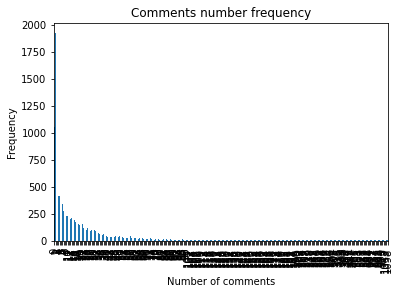

In [0]:
# Plot the frequency of comments numbers
fig = reddit_corpus['comms_num'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Comments number frequency')
fig.set_xlabel('Number of comments')
fig.set_ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Frequency of number of words in posts')

Text(0.5, 0, 'Number of words in posts')

Text(0, 0.5, 'Frequency')

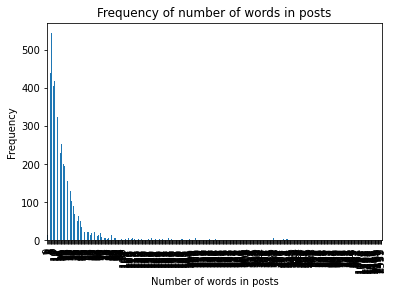

In [0]:
fig = reddit_corpus['word_len_posts'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of number of words in posts')
fig.set_xlabel('Number of words in posts')
fig.set_ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Frequency of number of words in titles')

Text(0.5, 0, 'Number of words in titles')

Text(0, 0.5, 'Frequency')

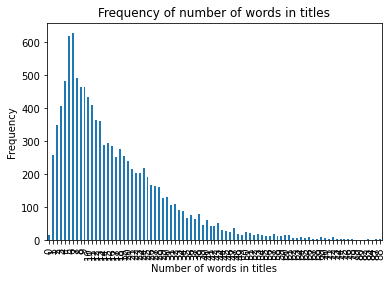

In [0]:
fig = reddit_corpus['word_len_en_titles'].value_counts().sort_index().plot(kind='bar')
fig.set_title('Frequency of number of words in titles')
fig.set_xlabel('Number of words in titles')
fig.set_ylabel('Frequency')
plt.show()

In [0]:
# Preprocess the posts text in corpus
def preprocess(document):
    document = str(document)
    # Contractions 
    document = contractions.fix(document)
    # Lowercasing
    document = document.lower()
    # Remove any whitespaces
    document = re.sub(r'[^\w\s]', ' ', document)
    document = re.sub(r'[^a-z ]', '', document)
    # Word Tokenize
    document = word_tokenize(document)
    # Stopwords
    stop_words = stopwords.words('english')
    document = [word for word in document if word not in stop_words]
    # Lemmatizer
    document = ' '.join(document)
    document = [word.lemma_ for word in nlp(document)]
    # Change the output to a sentence
    document = ' '.join(document)

    return document

In [0]:
reddit_corpus['posts_prep'] = [preprocess(document) for document in reddit_corpus['posts'].to_list()]
reddit_corpus.head(2)

,title,score,comms_num,time,body,en_titles,en_bodies,posts,word_len_posts,word_len_comms,word_len_en_titles,word_len_en_bodies,word_len_ro_titles,word_len_ro_bodies,posts_prep
0,protocol de tratament coronavirus RO,0,5,2020-03-17 05:20:49,nan,the protocol for the treatment of a coronaviru...,nan,the protocol for the treatment of a coronaviru...,9,109,9,0,5,0,protocol treatment coronavirus ro
1,Ce soluții credeți ca ar trebui implementate î...,0,1,2020-03-17 08:34:17,nan,What do you think it would have to be implemen...,nan,What do you think it would have to be implemen...,21,43,21,0,15,0,think would implement come period fight corona...


In [0]:
# Save the corpus in a csv
reddit_corpus.to_csv(os.path.join("data", "reddit_corpus_cleaned.csv"), index=False)

# Bag of words top 5000

In [0]:
corpus_posts = reddit_corpus['posts_prep']

In [0]:
# Create dtm (document term matrix) for most frequent 5000 words
vec_posts = CountVectorizer(max_features=5000)
counts_per_post = vec_posts.fit_transform(corpus_posts)
counts_per_post

<10771x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 117526 stored elements in Compressed Sparse Row format>

In [0]:
posts_words = vec_posts.get_feature_names()
posts_words[1700]

'few'

In [0]:
dtm_posts = pd.DataFrame(counts_per_post.toarray(), columns = posts_words)
dtm_posts.head(6)

,aa,abandon,abbot,abc,abide,ability,able,abolish,abolition,abortion,abroad,absence,absent,absolute,absolutely,absorb,abu,abuse,abusive,academic,academy,accelerate,accept,acceptable,access,accessible,accessory,accident,accommodation,accompany,accomplishment,accord,accordance,account,accusation,accuse,achieve,achievement,acid,acknowledge,...,worst,worth,worthy,would,wound,wow,wrap,write,writing,wrong,wtf,wuhan,xb,xi,xp,yard,yay,yeah,year,years,yeast,yell,yellow,yes,yesterday,yet,yo,york,young,youth,youtu,youtube,youtuber,yum,zamboanga,zdob,zdub,zero,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
# Create new column that contains only the words in DTM (from the 5000 words)
reddit_corpus['posts_prep_lim'] = reddit_corpus['posts_prep'].apply(word_tokenize)
reddit_corpus.head(2)

,title,score,comms_num,time,body,en_titles,en_bodies,posts,word_len_posts,word_len_comms,word_len_en_titles,word_len_en_bodies,word_len_ro_titles,word_len_ro_bodies,posts_prep,posts_prep_lim
0,protocol de tratament coronavirus RO,0,5,2020-03-17 05:20:49,nan,the protocol for the treatment of a coronaviru...,nan,the protocol for the treatment of a coronaviru...,9,109,9,0,5,0,protocol treatment coronavirus ro,"[protocol, treatment, coronavirus, ro]"
1,Ce soluții credeți ca ar trebui implementate î...,0,1,2020-03-17 08:34:17,nan,What do you think it would have to be implemen...,nan,What do you think it would have to be implemen...,21,43,21,0,15,0,think would implement come period fight corona...,"[think, would, implement, come, period, fight,..."


In [0]:
# Check in the 5000 words and see if text_prep words are in there
reddit_corpus['posts_prep_lim'] = reddit_corpus['posts_prep_lim'].apply(lambda x:[word for word in x if word in posts_words])
reddit_corpus.head(2)

,title,score,comms_num,time,body,en_titles,en_bodies,posts,word_len_posts,word_len_comms,word_len_en_titles,word_len_en_bodies,word_len_ro_titles,word_len_ro_bodies,posts_prep,posts_prep_lim
0,protocol de tratament coronavirus RO,0,5,2020-03-17 05:20:49,nan,the protocol for the treatment of a coronaviru...,nan,the protocol for the treatment of a coronaviru...,9,109,9,0,5,0,protocol treatment coronavirus ro,"[protocol, treatment, coronavirus, ro]"
1,Ce soluții credeți ca ar trebui implementate î...,0,1,2020-03-17 08:34:17,nan,What do you think it would have to be implemen...,nan,What do you think it would have to be implemen...,21,43,21,0,15,0,think would implement come period fight corona...,"[think, would, implement, come, period, fight,..."


In [0]:
# Get no of words
reddit_corpus['word_len_posts_lim'] = reddit_corpus['posts_prep_lim'].apply(len)

reddit_corpus.head(2)

,title,score,comms_num,time,body,en_titles,en_bodies,posts,word_len_posts,word_len_comms,word_len_en_titles,word_len_en_bodies,word_len_ro_titles,word_len_ro_bodies,posts_prep,posts_prep_lim,word_len_posts_lim
0,protocol de tratament coronavirus RO,0,5,2020-03-17 05:20:49,nan,the protocol for the treatment of a coronaviru...,nan,the protocol for the treatment of a coronaviru...,9,109,9,0,5,0,protocol treatment coronavirus ro,"[protocol, treatment, coronavirus, ro]",4
1,Ce soluții credeți ca ar trebui implementate î...,0,1,2020-03-17 08:34:17,nan,What do you think it would have to be implemen...,nan,What do you think it would have to be implemen...,21,43,21,0,15,0,think would implement come period fight corona...,"[think, would, implement, come, period, fight,...",7


In [0]:
# Save the dtms
dtm_posts.to_csv("data/dtm_posts_bow.csv", index=False)
reddit_corpus.to_csv('data/reddit_corpus_cleaned.csv', index=False)

# Wordcloud

In [0]:
wordcloud_freq_posts = dtm_posts.sum(axis=0)
wordcloud_freq_posts

aa          3
abandon    12
abbot       3
abc         3
abide       6
           ..
zdob        3
zdub        3
zero       12
zone       46
zoom       13
Length: 5000, dtype: int64

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'Worcloud of top 100 words in Reddit posts')

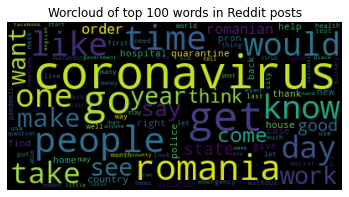

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'Worcloud of top 50 words in Reddit posts')

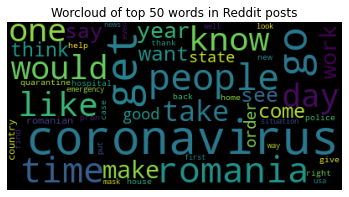

(-0.5, 399.5, 199.5, -0.5)

Text(0.5, 1.0, 'Worcloud of top 20 words in Reddit posts')

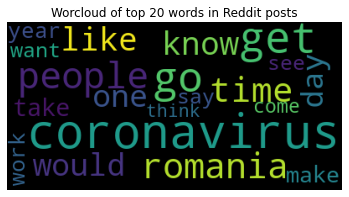

In [0]:
for i in [100,50,20]:
    wordcloud_posts = WordCloud(max_words=i, background_color = 'black', colormap = None)
    wordcloud_posts.generate_from_frequencies(wordcloud_freq_posts)
    plt.imshow(wordcloud_posts)
    plt.axis('off')
    plt.title(f"Worcloud of top {i} words in Reddit posts")
    plt.show()

# Word Frequency

In [0]:
word_freq_posts = pd.DataFrame(wordcloud_freq_posts).reset_index()
word_freq_posts.columns = ['Word', 'Count']
word_freq_posts.head()

,Word,Count
0,aa,3
1,abandon,12
2,abbot,3
3,abc,3
4,abide,6


In [0]:
# Let's check the most frequent words
word_freq_posts = word_freq_posts.sort_values(by='Count', ascending=False)

In [0]:
# Let's create a barchart of frequencies
top20_posts = word_freq_posts[0:19].copy()
top20_posts

,Word,Count
1041,coronavirus,1735
1908,get,1397
1932,go,1356
3255,people,1047
3802,romania,979
4494,time,918
2590,like,823
2491,know,819
4963,would,764
3104,one,750


<BarContainer object of 19 artists>

Text(0.5, 1.0, 'Top 20 words in posts')

Text(0.5, 0, 'Frequency')

Text(0, 0.5, 'Word')

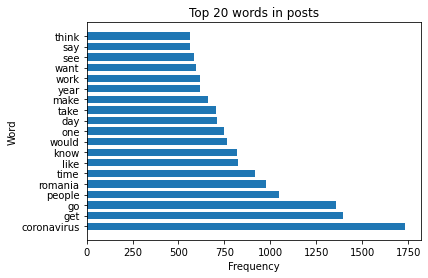

In [0]:
plt.barh(y=top20_posts['Word'],width=top20_posts['Count'], height = 0.7)
plt.title("Top 20 words in posts")
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show() 

In [0]:
final_list = []
for word in top20_posts["Word"]:
    final_list.append(word)

# Text representation
## Using fast text

In [0]:
# Create corpus vectors from the top 5000 words in the comments and posts
corpus_posts = reddit_corpus['posts_prep_lim']

In [0]:
final_size = 60
window_size = 10 
min_word = 3 
corpus_posts

0                   [protocol, treatment, coronavirus, ro]
1        [think, would, implement, come, period, fight,...
2                             [say, crisis, real, country]
3        [novel, think, happen, go, today, available, y...
4        [vel, pitar, suck, notice, fucking, thing, vel...
                               ...                        
10766                                                   []
10767                         [contrast, water, lake, pet]
10768                [see, meme, compass, policy, fashion]
10769    [seem, go, way, fast, nation, time, want, brin...
10770                                      [country, folk]
Name: posts_prep_lim, Length: 10771, dtype: object

In [0]:
# Create the fast text models for both vectors
%%time
model_posts = FastText(size=final_size, 
                 window=window_size, 
                 min_count=min_word, 
                 seed=1, 
                 workers=1)
model_posts.build_vocab(sentences = corpus_posts)
model_posts.train(sentences=corpus_posts, total_examples=len(corpus_posts), epochs=50) 

CPU times: user 1min 58s, sys: 348 ms, total: 1min 58s
Wall time: 1min 59s


In [0]:
# 60-dimensional vector for the word "coronavirus"
model_posts.wv['coronavirus']

array([ 0.3736171 , -1.8507665 , -2.6955833 , -1.0728503 ,  1.1630036 ,
        1.8375171 ,  0.05505038,  1.9314376 ,  0.6694291 , -2.262785  ,
       -0.52609384,  0.06211508, -1.548455  , -0.10281044,  1.1891301 ,
        0.708779  ,  1.2753204 , -0.6923459 ,  0.29580003, -2.7051098 ,
       -1.2388827 , -0.01894458,  0.39560148, -1.347857  ,  0.48376173,
        0.21215264,  0.7041011 ,  1.0254722 , -1.5176536 ,  0.7119307 ,
       -0.87565005, -0.49059662, -0.36967298, -0.51689124,  0.12214442,
        0.5318613 , -0.5351803 ,  0.8355386 , -2.2690215 ,  0.6567191 ,
       -1.4702696 , -0.8934633 ,  1.1472901 , -0.74060965, -0.9761517 ,
        0.72242075, -1.4817295 ,  0.24525078,  0.6235076 , -0.9056102 ,
       -0.37459913, -0.2968839 , -0.07929188, -2.0080652 ,  1.6066418 ,
       -1.4365711 , -1.4427499 , -0.6295253 , -0.10394575,  0.31919497],
      dtype=float32)

In [0]:
model_posts.wv.most_similar('coronavirus', topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



[('coronavirusu', 0.9414242506027222),
 ('coronavirusro', 0.7684302926063538),
 ('corona', 0.6870463490486145),
 ('virus', 0.6330421566963196),
 ('pneumonia', 0.5763275623321533)]

In [0]:
model_posts.wv.similarity(w1='coronavirus', w2='pneumonia')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



0.5763276

In [0]:
# Save the model
pickle.dump(model_posts, open('data/fast_text_model_posts.pkl', 'wb'))

In [0]:
# Visualize the model 
X_posts = model_posts.wv[final_list]
X_posts #an array with all 60-D vectors for all the words in final_list

array([[ 0.3736171 , -1.8507665 , -2.6955833 , ..., -0.6295253 ,
        -0.10394575,  0.31919497],
       [-3.3010993 ,  1.1099304 ,  2.376013  , ...,  0.7189364 ,
         1.761529  , -2.2199948 ],
       [-5.4580493 ,  3.923969  ,  1.3754307 , ...,  4.943132  ,
         3.143048  ,  1.9240961 ],
       ...,
       [-3.462457  ,  1.7481143 ,  7.7089458 , ...,  1.8412775 ,
        -0.26503998,  1.2497971 ],
       [-3.5138054 ,  2.3875136 ,  4.515077  , ...,  4.035753  ,
         3.1944616 ,  4.1082296 ],
       [-3.6905606 ,  2.8120914 ,  1.4618015 , ...,  0.3926692 ,
        -1.770737  ,  0.42389336]], dtype=float32)

In [0]:
# To plot sth nice let's reduce the 60 dimensions to 2
pca_posts = PCA(n_components=2).fit_transform(X_posts)
pca_posts

array([[ 2.7998834 , -7.191809  ],
       [-1.9332033 ,  8.622867  ],
       [-3.5175266 , 14.656286  ],
       [ 1.7743263 , -4.294469  ],
       [ 3.7680678 , -8.32228   ],
       [ 3.4703894 , -2.1138775 ],
       [-6.0919585 , -6.4061213 ],
       [-4.3446875 ,  0.074839  ],
       [-5.1440797 , -3.831744  ],
       [-0.5589378 , -2.8473341 ],
       [18.270063  ,  7.7887335 ],
       [-7.426854  ,  0.7498548 ],
       [-3.3049355 , -2.1594803 ],
       [15.760467  , -2.5588849 ],
       [ 4.645935  ,  2.6258187 ],
       [-0.15557246, -1.8278837 ],
       [-9.031565  ,  0.14433987],
       [-5.8889194 ,  6.70045   ],
       [-3.090893  ,  0.19069563]], dtype=float32)

In [0]:
fig = px.scatter(x = pca_posts[:,0], y = pca_posts[:,1], text = final_list)
fig.update_traces(textposition='top center', textfont_size=14)
fig.show()
# Which words tend to cluster together?